# Pr&aacute;ctica 4: Sensado de señales fisiológicas

<style>
    .imagen-ajustada {
        width: 900px;
        height: 280px;
        border-radius: 20px;
    }
</style>

<img src="electro.jpg" alt="Una imagen" class="imagen-ajustada">

Esta pr&aacute;ctica tuvo como objetivo comprender como se siente una persona en una situaci&oacute;n de estres, en este caso se tuvo como prueba la presentacion de avance de proyecto de la materia de ciencia de datos para sensores inteligentes. Se sensaron los datos fisiologicos por medio de un sensor de frecuencia cardiaca Polar H10 mientras se explicaba el avance, tambien se grabo la exposicion y por ultimo los doctores hicieron preguntas que nos resultaran estresantes y asi tomar los datos requeridos.

## Librer&iacute;as Importadas

In [2]:
import os
import pandas as pd
import matplotlib.pyplot as plt
import re
import spacy as spc
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from sklearn.feature_extraction.text import CountVectorizer

## Manejo del dataset

In [9]:
path = './Fisiologico/'
list_dir = os.listdir(path=path)
fisiological_data = {}
for dir in list_dir:
    if dir.startswith("Videos") or dir.startswith("Audios"):
        continue
    file = dir.upper()
    fisiological_data[file] = pd.read_csv(path + dir +"/"+ file + ".txt")

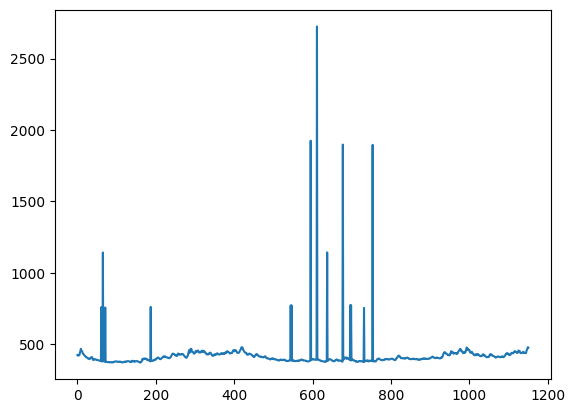

In [10]:
fisiological_data["SCARLETT"]

plt.plot(fisiological_data["SCARLETT"])

## Procesamiento de datos

## An&aacute;lisis Exploratorio 

## Segmentaci&oacute;n 

## Extracci&oacute;n de Caracter&iacute;sticas

### Info Gain

## Modelos a Evaluar

## Entrenando el Mejor modelo

## Validaci&oacute;n 

## Conclusiones